In [ ]:
# # setup for the colab

# import os
# os.environ['KAGGLE_USERNAME'] = "kirillfedyanin"
# os.environ['KAGGLE_KEY'] = ""
# !pip install imageio
# !pip install keras 
# !pip install kaggle

# !kaggle competitions download -c tgs-salt-identification-challenge
# !mkdir -p test
# !mkdir -p train
# !unzip test.zip -d test
# !unzip train.zip -d train

In [ ]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage.transform import resize

In [ ]:
HEIGHT, WIDTH = 101, 101

In [573]:
root_path = './'

def get_image(file_id, mode='train'):
    image_path = os.path.join(root_path, mode, "images", file_id + '.png')
    image = np.array(imageio.imread(image_path), dtype=np.uint8)
    return image

def get_mask(file_id):
    mask_path = os.path.join(root_path, "train", "masks", file_id + '.png')
    mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
    return mask

In [566]:
train_values = pd.read_csv('train.csv')
file_list = list(train_values['id'])

# Reasearch
Do some data digging

In [574]:
def rle_to_mask(rle_string):
    if isinstance(rle_string, float) and np.isnan(rle_string):
        return np.zeros((HEIGHT, WIDTH)) 
    rle_numbers = [int(num) for num in rle_string.split()] 
    rle_pairs = np.array(rle_numbers).reshape((-1, 2))
    
    mask = np.zeros(HEIGHT*WIDTH)
    for start, length in rle_pairs:
        mask[start-1: start-1+length] = 255
    
    mask = mask.reshape((HEIGHT, WIDTH)).T
        
    return mask


3352 is correct:  True
510 is correct:  True
1269 is correct:  True
3692 is correct:  True
539 is correct:  True
3701 is correct:  True
1535 is correct:  True
3106 is correct:  True
381 is correct:  True
1409 is correct:  True
3104 is correct:  True
1114 is correct:  True
2323 is correct:  True
453 is correct:  True
2991 is correct:  True


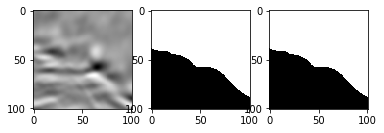

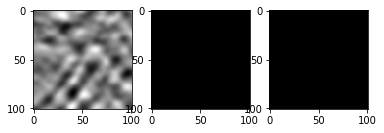

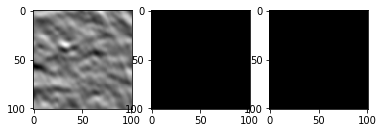

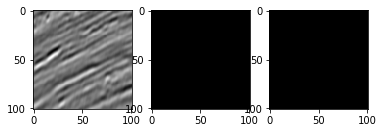

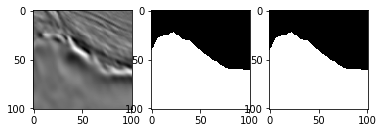

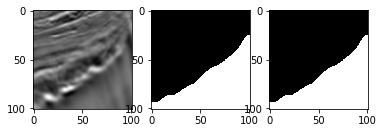

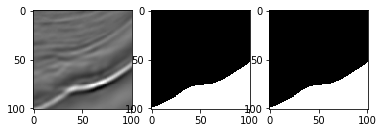

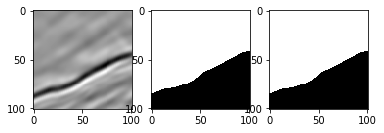

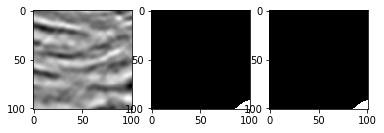

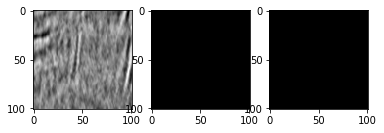

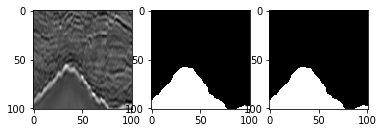

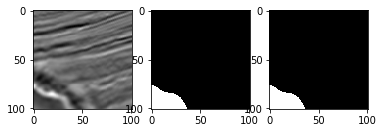

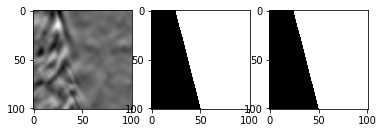

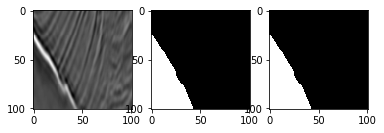

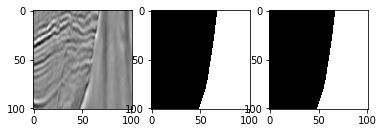

In [575]:
# check if masks correctly oriented
for _ in range(15):
    i = random.randint(0, len(dataset)-1) 
    file_id = file_list[i]
    image, mask = get_image(file_id), get_mask(file_id)
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap='gray')
    axarr[2].imshow(rle_to_mask(train_values['rle_mask'][i]), cmap='gray')
    print(i, 'is correct: ', (mask==rle_to_mask(train_values['rle_mask'][i])).all())
    

In [ ]:
depths = pd.read_csv("depths.csv")

train_values['depths'] = depths['z']

plt.figure(figsize=(6, 6))
plt.hist(train_values['depths'], bins=50)


In [ ]:
norm = HEIGHT * WIDTH * 255.0
def salt_concentration(mask):
    return np.sum(mask)/norm

masks = [get_mask(file_id) for file_id in train_values['id']]
train_values['salt_concentration'] = [salt_concentration(mask) for mask in masks]

In [ ]:
train_val = train_values.merge(depths, how='left')

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(train_val['salt_concentration'], train_val['depths'])
plt.title("Depths vs salt concentration")

# Model training itself

**what to do**
- dropout
- model saving
- postprocess
- unet connections
- regularization


In [549]:
from keras.layers import Input, Dense, Conv2D, UpSampling2D, MaxPooling2D, concatenate, ZeroPadding2D, Cropping2D
from keras.models import Model

def salt_detector():
    common_atr = {'activation': 'relu', 'padding': 'same'}
    
    input_image = Input(shape=(101, 101, 1))
    x = ZeroPadding2D(((0, 27), (0, 27)))(input_image)
    conv1 = Conv2D(16, (3, 3), **common_atr)(x)
    conv1 = Conv2D(16, (3, 3), **common_atr)(conv1)
    max1 = MaxPooling2D((2, 2), padding='same')(conv1)
    
    conv2 = Conv2D(32, (3, 3), **common_atr)(max1)
    conv2 = Conv2D(32, (3, 3), **common_atr)(conv2)
    max2 = MaxPooling2D((2, 2), padding='same')(conv2)
    
    conv3 = Conv2D(64, (3, 3), **common_atr)(max2)
    conv3 = Conv2D(64, (3, 3), **common_atr)(conv3)
    encoded = MaxPooling2D((2, 2), padding='same')(conv3)
    
    conv10 = Conv2D(64, (3, 3), **common_atr)(encoded)
    conv10 = Conv2D(64, (3, 3), **common_atr)(conv10)
    
    up11 = UpSampling2D((2, 2))(conv10)
    merged11 = concatenate([up11, conv3], axis=3)
    conv11 = Conv2D(32, (3, 3), **common_atr)(merged11)
    conv11 = Conv2D(32, (3, 3), **common_atr)(conv11)
    
    up12 = UpSampling2D((2, 2))(conv11)
    merged12 = concatenate([up12, conv2], axis=3)
    conv12 = Conv2D(16, (3, 3), **common_atr)(merged12)
    conv12 = Conv2D(16, (3, 3), **common_atr)(conv12)
    
    up13 = UpSampling2D((2, 2))(conv12)
    merged13 = concatenate([up13, conv1], axis=3)
    conv13 = conv12 = Conv2D(16, (3, 3), **common_atr)(merged13)
    conv13 = conv12 = Conv2D(16, (3, 3), **common_atr)(conv13)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv13)
    decoded_cropped = Cropping2D(((0, 27), (0, 27)))(decoded)
    
    autoencoder = Model(input_image, decoded_cropped)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return autoencoder

detector = salt_detector()
detector.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_15 (ZeroPadding2 (None, 128, 128, 1)  0           input_37[0][0]                   
__________________________________________________________________________________________________
conv2d_378 (Conv2D)             (None, 128, 128, 16) 160         zero_padding2d_15[0][0]          
__________________________________________________________________________________________________
conv2d_379 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_378[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [ ]:
def prepare(images):
    images = np.stack(images)
    images = images[:, :, :, :1].astype('float32') / 255.
    return images

In [ ]:
labels = prepare([get_mask(file_id)[:,:,np.newaxis] for file_id in file_list])
images = prepare([get_image(file_id) for file_id in file_list])

In [ ]:
val_size = 512
images_train, images_val = images[:-val_size], images[-val_size:]
labels_train, labels_val = labels[:-val_size], labels[-val_size:]

In [554]:
detector.fit(images_train, labels_train, epochs=5, batch_size=64, shuffle=True, validation_data=(images_val, labels_val) )

Train on 3488 samples, validate on 512 samples
Epoch 1/5
3488/3488 [==============================] - 103s 29ms/step - loss: 0.5610 - val_loss: 0.5534
Epoch 2/5
3488/3488 [==============================] - 101s 29ms/step - loss: 0.5563 - val_loss: 0.5415
Epoch 3/5
3488/3488 [==============================] - 102s 29ms/step - loss: 0.5407 - val_loss: 0.5107
Epoch 4/5
3488/3488 [==============================] - 100s 29ms/step - loss: 0.5335 - val_loss: 0.5156
Epoch 5/5
3488/3488 [==============================] - 102s 29ms/step - loss: 0.5178 - val_loss: 0.6349


In [559]:
def threshold_image(image, threshold=0.5):
    image[image>threshold] = 1
    image[image<=threshold] = 0
    return image

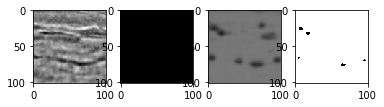

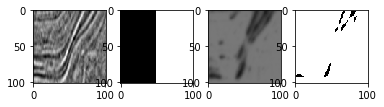

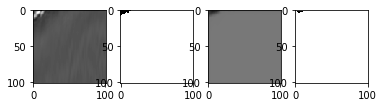

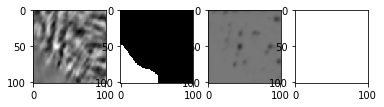

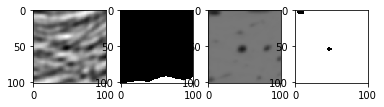

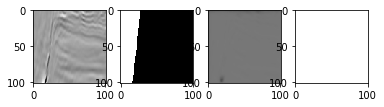

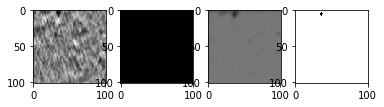

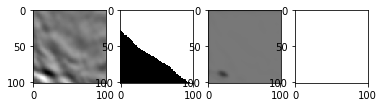

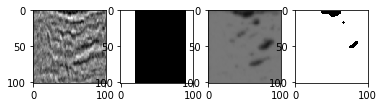

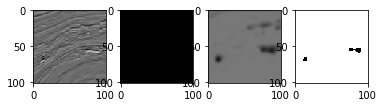

In [561]:
for i in range(10):
    image = images[i]
    label = labels[i]
    prediction = detector.predict(images[i:i+1])[0]
    _, axarr = plt.subplots(1, 4)
    axarr[0].imshow(image[:, :, 0], cmap='gray')
    axarr[1].imshow(label[:, :, 0], cmap='gray', vmin=0, vmax=1)
    axarr[2].imshow(prediction[:, :, 0], cmap='gray', vmin=0, vmax=1)
    axarr[3].imshow(threshold_image(prediction[:, :, 0], 0.2), cmap='gray', vmin=0, vmax=1)


In [620]:
def encode_rle(mask):
    mask = mask.reshape(HEIGHT, WIDTH).T.reshape(-1)
    
    rle_array = []
    white_start = 0 
    for i, value in enumerate(mask):
        if value == 0 and white_start:
            rle_array.extend([white_start, i+1-white_start])
            white_start = 0
        elif value == 1 and not white_start:
            white_start = i + 1
    if white_start:
        rle_array.extend([white_start, len(mask)+1-white_start])
                
    rle_encoded = ' '.join(map(str, rle_array))
    return rle_encoded

In [621]:
# validate rle encoder
for some_index in range(99):
    file_id_ = file_list[some_index]
    msk = get_mask(file_id_) / 255.0
    correct_mask = train_values['rle_mask'][some_index]
    encoded = encode_rle(msk)
    print(encoded == correct_mask or (not encoded and np.isnan(correct_mask)), end= ' ')

True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True 